# Knife-edge beam profile measurement

Code developed by Nishant Bhatt, adapted and annotated by Shira Jackson

## Introduction

The measurement of laser beam waist (radius) is important for many applications such selecting lenses, estimating atomic signals sizes, and mode-matching to cavities. 

For a gaussian $\text{TEM}_{00}$ beam, the waist is usually defined as the gaussian width $\sigma$ also known as the standard deviation or the $1/e^2$ width. (Note that other definitions exist, such as the half-width half-maximum, the 10/90 width, or the $D4\sigma$ width which is useful for beam profiles with multiple peaks.)

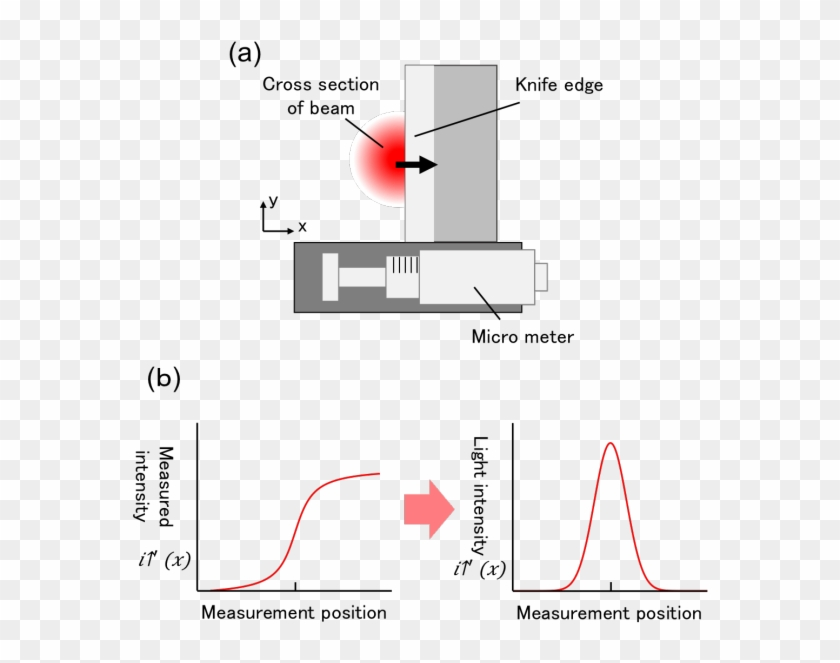

(Image from https://en.symphotony.com/products/laseview-lineup/soft/)

One simple way to measure the beam waist is to use a knife-edge. A knife or razor is used to slice a laser beam and the power of the clipped beam is measured as a function of the knife's position across the beam. This is equivalent to measuring the integrated beam power which, for a gaussian beam, is an error function. 

The beam waist can be calculated from this data by fitting to an error function:

$$ \operatorname{erf}x = a \sigma \int_0^{x} e^{- \left(\frac{(x-b)}{2\sigma} \right)^2} dx $$


or by differentiating the data and fitting to a gaussian:

$${\displaystyle f(x)=a\cdot e^{- \left(\frac{(x-b)}{2\sigma} \right)^2}} $$

The following code uses both methods.

(Note that if your beam is assymetric you may want to perform a knife-edge scan in both x and y directions.)

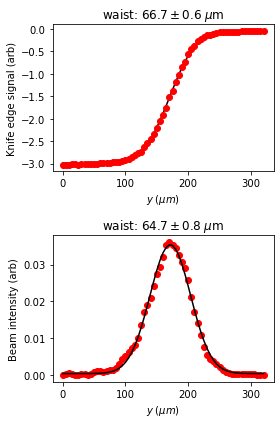

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf

# Smooth Differentiating functions
def DiffSmooth(x,y,order):
    """Returns the derivative of y wrt x calculated numerically."""
    dx = x[1]-x[0]
    nmax = 5
    npad = nmax+1
    pad_left = np.ones(npad)*y[0]
    pad_right = np.ones(npad)*y[-1]
    yp = np.concatenate((pad_left,y,pad_right))

    delY = []
    for i in range(1,nmax+1):
        delY.append((yp[npad+i:-npad+i]-yp[npad-i:-npad-i])/dx)
    del_factors = [ [1/2.0, 0.0, 0.0, 0.0, 0.0], \
    [2.0/8.0, 1.0/8.0, 0.0, 0.0, 0.0], \
    [5.0/32.0, 4.0/32.0, 1.0/32.0, 0.0, 0.0], \
    [14.0/128.0, 14.0/128.0, 6.0/128.0, 1.0/128.0, 0.0], \
    [42.0/512.0, 48.0/512.0, 27.0/512.0, 8.0/512.0, 1.0/512.0] ]
    Dy = np.zeros(x.shape)
    for i in range(nmax):
        Dy = Dy + delY[i]*del_factors[order-1][i]
    return Dy


def Erf(x, amp, center, width, disp):
    """Returns an erf with the given parameters."""
    return amp*width*(erf(np.sqrt(2)*(x-center)/width))+disp

def Gaussian(x, amp, center, width, disp):
    """Returns an erf with the given parameters."""
    return amp*np.exp(-2.0*(x-center)**2/width**2)+disp

def FitErf(x,Ic):
    dIc = DiffSmooth(x,Ic,3)
    # calculate initial guesses for the fitting parameters
    dIpeak = np.max(dIc)
    x_peak = x[np.argmax(dIc)]
    dIsd = dIpeak*np.exp(-2.0)
    x_waist = x[np.argmin(np.abs(dIc-dIsd))]
    w_c = np.abs(x_waist-x_peak)
    amp_c = dIpeak
    center_c = x_peak
    disp_c = np.min(Ic)
    # do a least squares fit for I
    popt, pcov = curve_fit(Erf,x,Ic,(amp_c, center_c, w_c, disp_c))
    popt_g, pcov_g = curve_fit(Gaussian,x,dIc,(amp_c, center_c, w_c, disp_c))
    return popt, pcov, popt_g, pcov_g


# to load data from a file:
fdir = '/path/to/data/'
fname = 'file_name.txt'
#y, P = np.loadtxt(fdir+fname).T

# example data: P in arbitrary units, y in um
P = np.array([3.02,3.02,3.02,3.01,3.01,3.02,3.01,3.01,3.01,3.01,3.01,3,2.99,2.99,2.99,2.98,2.97,2.97,2.96,2.94,2.91,2.89,2.85,2.81,2.77,2.73,2.64,2.53,2.45,2.35,2.2,2.05,1.92,1.76,1.52,1.39,1.19,1.026,0.854,0.744,0.55,0.448,0.377,0.275,0.223,0.177,0.144,0.132,0.104,0.0898,0.0745,0.0687,0.0647,0.0616,0.0606,0.0583,0.0566,0.0549,0.0526,0.0536,0.0497,0.0507,0.0487,0.0488,0.0482])
y = np.linspace(0,320,num=len(P))

P = -P 

dP = DiffSmooth(y, P, 3)
popt, pcov, popt_g, pcov_g = FitErf(y, P)

Pfit = Erf(y, *popt)
dPfit = Gaussian(y, *popt_g)

plt.figure(figsize=(4, 3*2))
plt.subplot(211)
plt.plot(y, Pfit, '-', color='black')
plt.plot(y, P, 'o', color='red')
plt.xlabel('$y \; (\\mu m)$')
plt.ylabel('Knife edge signal (arb)')
plt.title('waist: $ %.1f \\pm %.1f \; \\mu$m'%(popt[2], pcov[2, 2]**0.5))

plt.subplot(212)
plt.plot(y, dP, 'o', color='red')
plt.plot(y, dPfit, '-', color='black')
plt.ylabel('Beam intensity (arb)')
plt.xlabel('$y \; (\\mu m)$')
plt.title('waist: $ %.1f \\pm %.1f \; \\mu$m'%(popt_g[2], pcov_g[2, 2]**0.5))

plt.tight_layout()
#plt.savefig(fdir+fname+'.png') #use to save your figure
plt.show()



In [ ]:
The top figure shows the raw data fit to an error function. 

The bottom figure shows the differentiated data fit to a gaussian function. 